In [1]:
import numpy as np
import pandas as pd
import h5py
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
    print("running on GPU")
else:
    print("running on CPU")
    dev = "cpu"
    
device = torch.device(dev)

running on CPU


In [3]:
class train_dataset(Dataset):
    def __init__(self):
        data = np.loadtxt('./data/train_data.txt', dtype=np.float32, delimiter=",", skiprows=1)
        self.x = torch.tensor(data[:, 1:-6])
        self.y = torch.tensor(data[:, [-1]])
        self.n_samples = data.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.n_samples

In [16]:
def train_supervised(model, train_loader, val_input, val_labels, save_model=False):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCELoss()
    loss_train_arr = []
    loss_val_arr = []
    acc_arr = []
    auc_arr = []
    bkg_rej = []
    for e in range(epochs):
        loss_sum = 0
        for i, (train_input, train_label) in enumerate(train_loader):
            train_input = train_input.to(device)
            train_label = train_label.to(device)
            label_pred = model(train_input)
            loss_train = loss_fn(label_pred, train_label.reshape(-1, 1))
            loss_sum += loss_train.item()
        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
    
        with torch.no_grad():
            val_label_pred = model(val_input)
            loss_val = loss_fn(val_label_pred, val_labels.reshape(-1, 1))
            acc_arr.append(1 - torch.sum(torch.abs(val_label_pred.round() - val_labels.reshape(-1, 1))).item()/len(val_labels))
            loss_train_arr.append(loss_sum/iterations)
            loss_val_arr.append(loss_val.item())
            auc_arr.append(roc_auc_score(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy()))
            fpr, tpr, thresholds = roc_curve(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy())
            bkg_rej.append(1/fpr[np.argmin(np.abs(tpr-0.3))])
                
        if e % 100 == 0:
            print("epoch: %d, loss: %.4f, accuracy: %.4f, AUC: %.4f, background rejection at 30 percent: %.4f" % (e, loss_sum/iterations, acc_arr[e], auc_arr[e], bkg_rej[e]))
        
        cut_epochs = 10

    plot_learning(epochs, cut_epochs, loss_train_arr, loss_val_array, acc_arr, auc_arr, bkg_rej)
    torch.save(model.state_dict(), './data/model_100per.pt')

In [20]:
def plot_learning(epochs, cut_epochs, loss_train_arr, loss_val_array, acc_arr, auc_arr, bkg_rej):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.plot(range(epochs)[cut_epochs:], loss_train_arr[cut_epochs:], label='loss training set')
    ax1.plot(range(epochs)[cut_epochs:], loss_val_arr[cut_epochs:], label='loss validation set')
    ax1.legend(loc='upper right')
    ax2.plot(range(epochs)[cut_epochs:], acc_arr[cut_epochs:], label='accuracy validation set')
    ax2.plot(range(epochs)[cut_epochs:], auc_arr[cut_epochs:], label='AUC validation set')
    ax2.legend(loc='lower right')
    ax3.plot(range(epochs)[cut_epochs:], bkg_rej[cut_epochs:])
    plt.show()

In [19]:
def evaluate(model, test_input, test_labels):
    with torch.no_grad():
        test_label_pred = model(test_input)
        print("accuracy test set: %.4f" % (1 - torch.sum(torch.abs(test_label_pred.round() - test_labels.reshape(-1, 1))).item()/len(test_labels)))
        print("AUC test set: %.4f" % (roc_auc_score(test_labels.cpu().detach().numpy(), test_label_pred.cpu().detach().numpy())))
        fpr, tpr, thresholds = roc_curve(test_labels.cpu().detach().numpy(), test_label_pred.cpu().detach().numpy())
        print("background rejection at 30 percent: %.4f" % (1/fpr[np.argmin(np.abs(tpr-0.3))]))
        plt.semilogy(tpr[fpr>0], 1/fpr[fpr>0]) 

In [5]:
val_data = np.loadtxt('./data/val_data.txt', dtype=np.float32, delimiter=",", skiprows=1)
val_input = torch.tensor(val_data[:, 1:-6]).to(device)
val_labels = torch.tensor(val_data[:, -1]).to(device)
test_data = np.loadtxt('./data/test_data.txt', dtype=np.float32, delimiter=",", skiprows=1)
test_input = torch.tensor(test_data[:, 1:-6]).to(device)
test_labels = torch.tensor(test_data[:, -1]).to(device)

In [6]:
model = torch.nn.Sequential(
    torch.nn.Linear(26, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
    torch.nn.Sigmoid()
)

model = model.to(device)
train_data = train_dataset()

151223
epoch: 0, loss: 0.1830, accuracy: 0.9260, AUC: 0.9778, background rejection at 30 percent: 505.7965
epoch: 2, loss: 0.1829, accuracy: 0.9260, AUC: 0.9779, background rejection at 30 percent: 504.5288
epoch: 4, loss: 0.1829, accuracy: 0.9260, AUC: 0.9779, background rejection at 30 percent: 505.7965
epoch: 6, loss: 0.1828, accuracy: 0.9260, AUC: 0.9779, background rejection at 30 percent: 507.0705
epoch: 8, loss: 0.1828, accuracy: 0.9260, AUC: 0.9779, background rejection at 30 percent: 507.0705


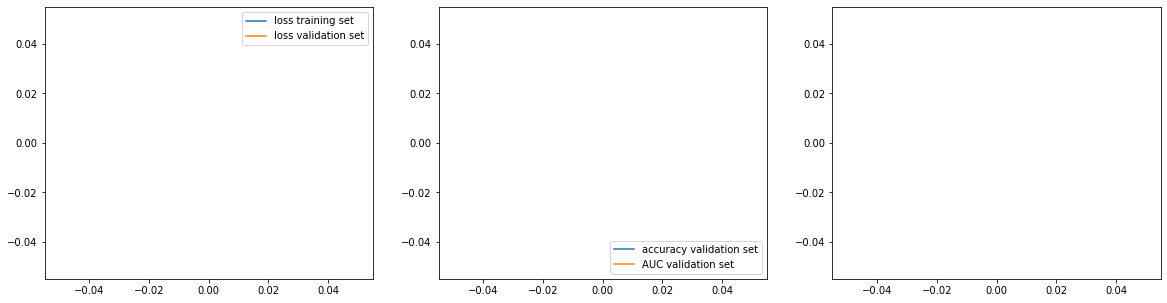

In [17]:
learning_rate = 0.1
epochs = 10
batch_size = 32
iterations = int(train_data.__len__()/batch_size)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
train_supervised(model, train_loader, val_input, val_labels)
evaluate(model, test_input, test_labels)

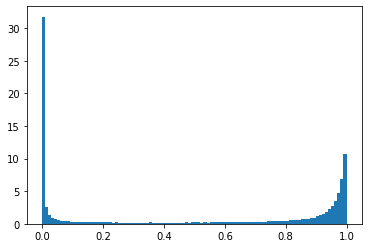

In [12]:
plt.hist(test_label_pred.detach().numpy(), density=True, bins=100)
plt.show()